In [1]:
from typing import Any
import numpy as np
import pandas as pd
from lisatools.diagnostic import snr as snr_func
from lisatools.diagnostic import plot_covariance_contour, plot_covariance_corner
from lisatools.sensitivity import get_sensitivity, A1TDISens
from lisatools.detector import scirdv1, Orbits, DefaultOrbits, LISAModel
from lisatools.utils.constants import *
from lisatools.sources import BBHCalculationController, GBCalculationController, EMRICalculationController
from lisatools.sources.emri import EMRITDIWaveform
from lisatools.sources.bbh import BBHSNRWaveform
from lisatools.sources.gb import GBAETWaveform

from gwspaceperf import Mission
from gwspaceperf.performance import sensitivity, noise_psd

from abc import ABC
from typing import Union, Tuple
import matplotlib.pyplot as plt
from scipy import interpolate

%matplotlib inline

No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU response available.
No CuPy or GPU interpolation available.


Define model class based on `lisatools.detector.LISAModel`. This interacts with the sensitivity curve generator inside `lisatools` to properly include model information.

In [2]:
class Space2050Model:
    """Model for future space-based GW missions.

    Args:
        mission: ``gwspaceperf.Mission``.
        orbits: ``lisatools.detector.Orbits``.
        name: Name for model instance.

    """

    def __init__(self, mission: Mission, orbits: Orbits, name: str):
        # store spline
        self.orbits = orbits
        self.name = name
        self._setup_splines(mission)

    @property
    def Sn_spl(self) -> interpolate.CubicSpline | None:
        """PSD spline dictionary."""
        if not hasattr(self, "_Sn_spl"):
            return None

        return self._Sn_spl

    @property
    def fn(self) -> np.ndarray:
        """Frequency array for splines."""
        return self._fn

    def _setup_splines(self, mission: Mission) -> None:
        """Prepare the splines accordingly"""
        Sn = noise_psd(mission, "AET")
        self._fn = mission.f
        self._Sn_spl = {
            key: interpolate.CubicSpline(self._fn, Sn[:, i])
            for i, key in enumerate(["A", "E", "T"])
        }

## Define mission characteristics

In [3]:
# Define a frequency axis
f_mu = np.logspace(-7, 0, 1000)
f_m = np.logspace(-4, 0, 1000)
f_d = np.logspace(-3, 1, 1000)

# Define the LISA-like mission
lisa_mission = Mission.LISA(f_m)
lisamax_mission = Mission.LISAmax(f_mu)
do_con_mission = Mission.DO_conservative(f_d)
do_opt_mission = Mission.DO_optimal(f_d)
# amigo = Mission.AMIGO(f_m)
muares_mission = Mission.muAres(f_mu)

In [4]:
missions = {}

def get_df(Tobs: float, dt: float) -> float:
    Nobs = int(Tobs / dt)
    Tobs = Nobs * dt
    df = 1 / Tobs
    return df


In [5]:
lisa_orbits = Orbits("../space_2050_models/lisa_orbits.h5", armlength=2.5e9)

lisa = Space2050Model(
    lisa_mission, lisa_orbits, "lisa"
)

psd_kwargs = dict(
    # stochastic_params=(10.0 * YRSID_SI,),
)

missions["lisa"] = dict(
    model=lisa,
    psd_kwargs=psd_kwargs,
    Tobs=YRSID_SI, 
    dt=10.0
)

In [6]:

lisamax_orbits = Orbits("../space_2050_models/lisamax_orbits.h5", armlength=2.59e+11)
lisa_max = Space2050Model(
    lisamax_mission, lisamax_orbits, "lisa_max"
)
psd_kwargs = dict(
    # stochastic_params=(10.0 * YRSID_SI,),
)
missions["lisamax"] = dict(
    model=lisa_max,
    psd_kwargs=psd_kwargs,
    Tobs=YRSID_SI, 
    dt=20.0
)

muares = Space2050Model(
    muares_mission, lisamax_orbits, "muares"
)
psd_kwargs = dict(
    # stochastic_params=(10.0 * YRSID_SI,),
)
missions["muares"] = dict(
    model=muares,
    psd_kwargs=psd_kwargs,
    Tobs=YRSID_SI, 
    dt=20.0
)

In [7]:
do_orbits = Orbits("../space_2050_models/deci_orbits.h5", armlength=1e8)

do_con = Space2050Model(
    do_con_mission, do_orbits, "do_con"
)

psd_kwargs = dict(
    # stochastic_params=(10.0 * YRSID_SI,),
)

missions["do_con"] = dict(
    model=do_con,
    psd_kwargs=psd_kwargs,
    Tobs=YRSID_SI / 2.0, 
    dt=0.5
)

do_opt = Space2050Model(
    do_opt_mission, do_orbits, "do_opt"
)

psd_kwargs = dict(
    # stochastic_params=(10.0 * YRSID_SI,),
)

missions["do_opt"] = dict(
    model=do_opt,
    psd_kwargs=psd_kwargs,
    Tobs=YRSID_SI / 2.0, 
    dt=0.5
)

## Diagnostics

Setup all snr calculators

In [8]:
for mission in missions:
    print(mission)
    orbits_here = missions[mission]["model"].orbits
    # black hole generator
    bbh = BBHSNRWaveform(response_kwargs=dict(TDItag="AET", orbits=orbits_here, tdi2=True))

    missions[mission]["bbh"] = BBHCalculationController(
        bbh, 
        missions[mission]["model"],
        missions[mission]["psd_kwargs"], 
        missions[mission]["Tobs"] / YRSID_SI,
        missions[mission]["dt"],
        psd=A1TDISens
    )
    
    # gb generator
    gb = GBAETWaveform(orbits=orbits_here)

    missions[mission]["gb"] = GBCalculationController(
        gb, 
        missions[mission]["model"], 
        missions[mission]["psd_kwargs"], 
        missions[mission]["Tobs"] / YRSID_SI,
        missions[mission]["dt"],
        psd=A1TDISens
    )

    # emri generator
    emri = EMRITDIWaveform(
        T=missions[mission]["Tobs"] / YRSID_SI,  # in sec
        dt=missions[mission]["dt"], 
        response_kwargs=dict(tdi="2nd generation", orbits=orbits_here)
    )

    missions[mission]["emri"] = EMRICalculationController(
        emri, missions[mission]["model"], 
        missions[mission]["psd_kwargs"], 
        missions[mission]["Tobs"] / YRSID_SI,  # in sec
        missions[mission]["dt"],
        psd=A1TDISens
    )
    


lisa
lisamax
muares
do_con
do_opt


### MBHBs

In [9]:
# in SSB

f_ref = 0.0  # let phenom codes set f_ref -> fmax = max(f^2A(f))
phi_ref = 0.5  # phase at f_ref
m1 = 1e6
m2 = 5e5
M = m1 + m2
q = m2 / m1  # m2 less than m1
a1 = 0.2
a2 = 0.4
dist = 10.0 * PC_SI * 1e9  # in m
inc = np.pi / 3.0
beta = np.pi / 4.0  # ecliptic latitude
lam = np.pi / 5.0  # ecliptic longitude
psi = np.pi / 6.0  # polarization angle

t_ref = YRSID_SI * 0.25  # (in the SSB reference frame)

mbh_injection_params = np.array(
    [m1, m2, a1, a2, dist, phi_ref, f_ref, inc, lam, beta, psi, t_ref]
)
fig, ax = plt.subplots(len(list(missions.keys())), 1, figsize=(8, 6))
for i, (name, mission) in enumerate(missions.items()):
    fn = mission["model"].fn
    print(name, mission["bbh"].get_snr(*mbh_injection_params))
    Sn = get_sensitivity(fn, model=mission["model"], sens_fn=A1TDISens, **mission["psd_kwargs"])
    ax[i].loglog(mission["bbh"].f_arr, mission["bbh"].f_arr * np.abs(mission["bbh"].last_output[0]), c=f"C{i}")
    df = get_df(mission["Tobs"], mission["dt"])
    ax[i].loglog(fn, np.sqrt(fn) * (Sn / (4 * df)) ** (1/2), c=f"C{i}", ls="--")


lisa 3711.279397743761
lisamax 533375.8476247393
muares 18963004.28887268
do_con 214.0162516143928
do_opt 214.34144312105994


In [10]:
# example with last mission
scaled_inj_params, cov = mission["bbh"].get_cov(
    *mbh_injection_params,
    precision=True,
    more_accurate=False,
    eps=1e-9,
    deriv_inds=None,
)


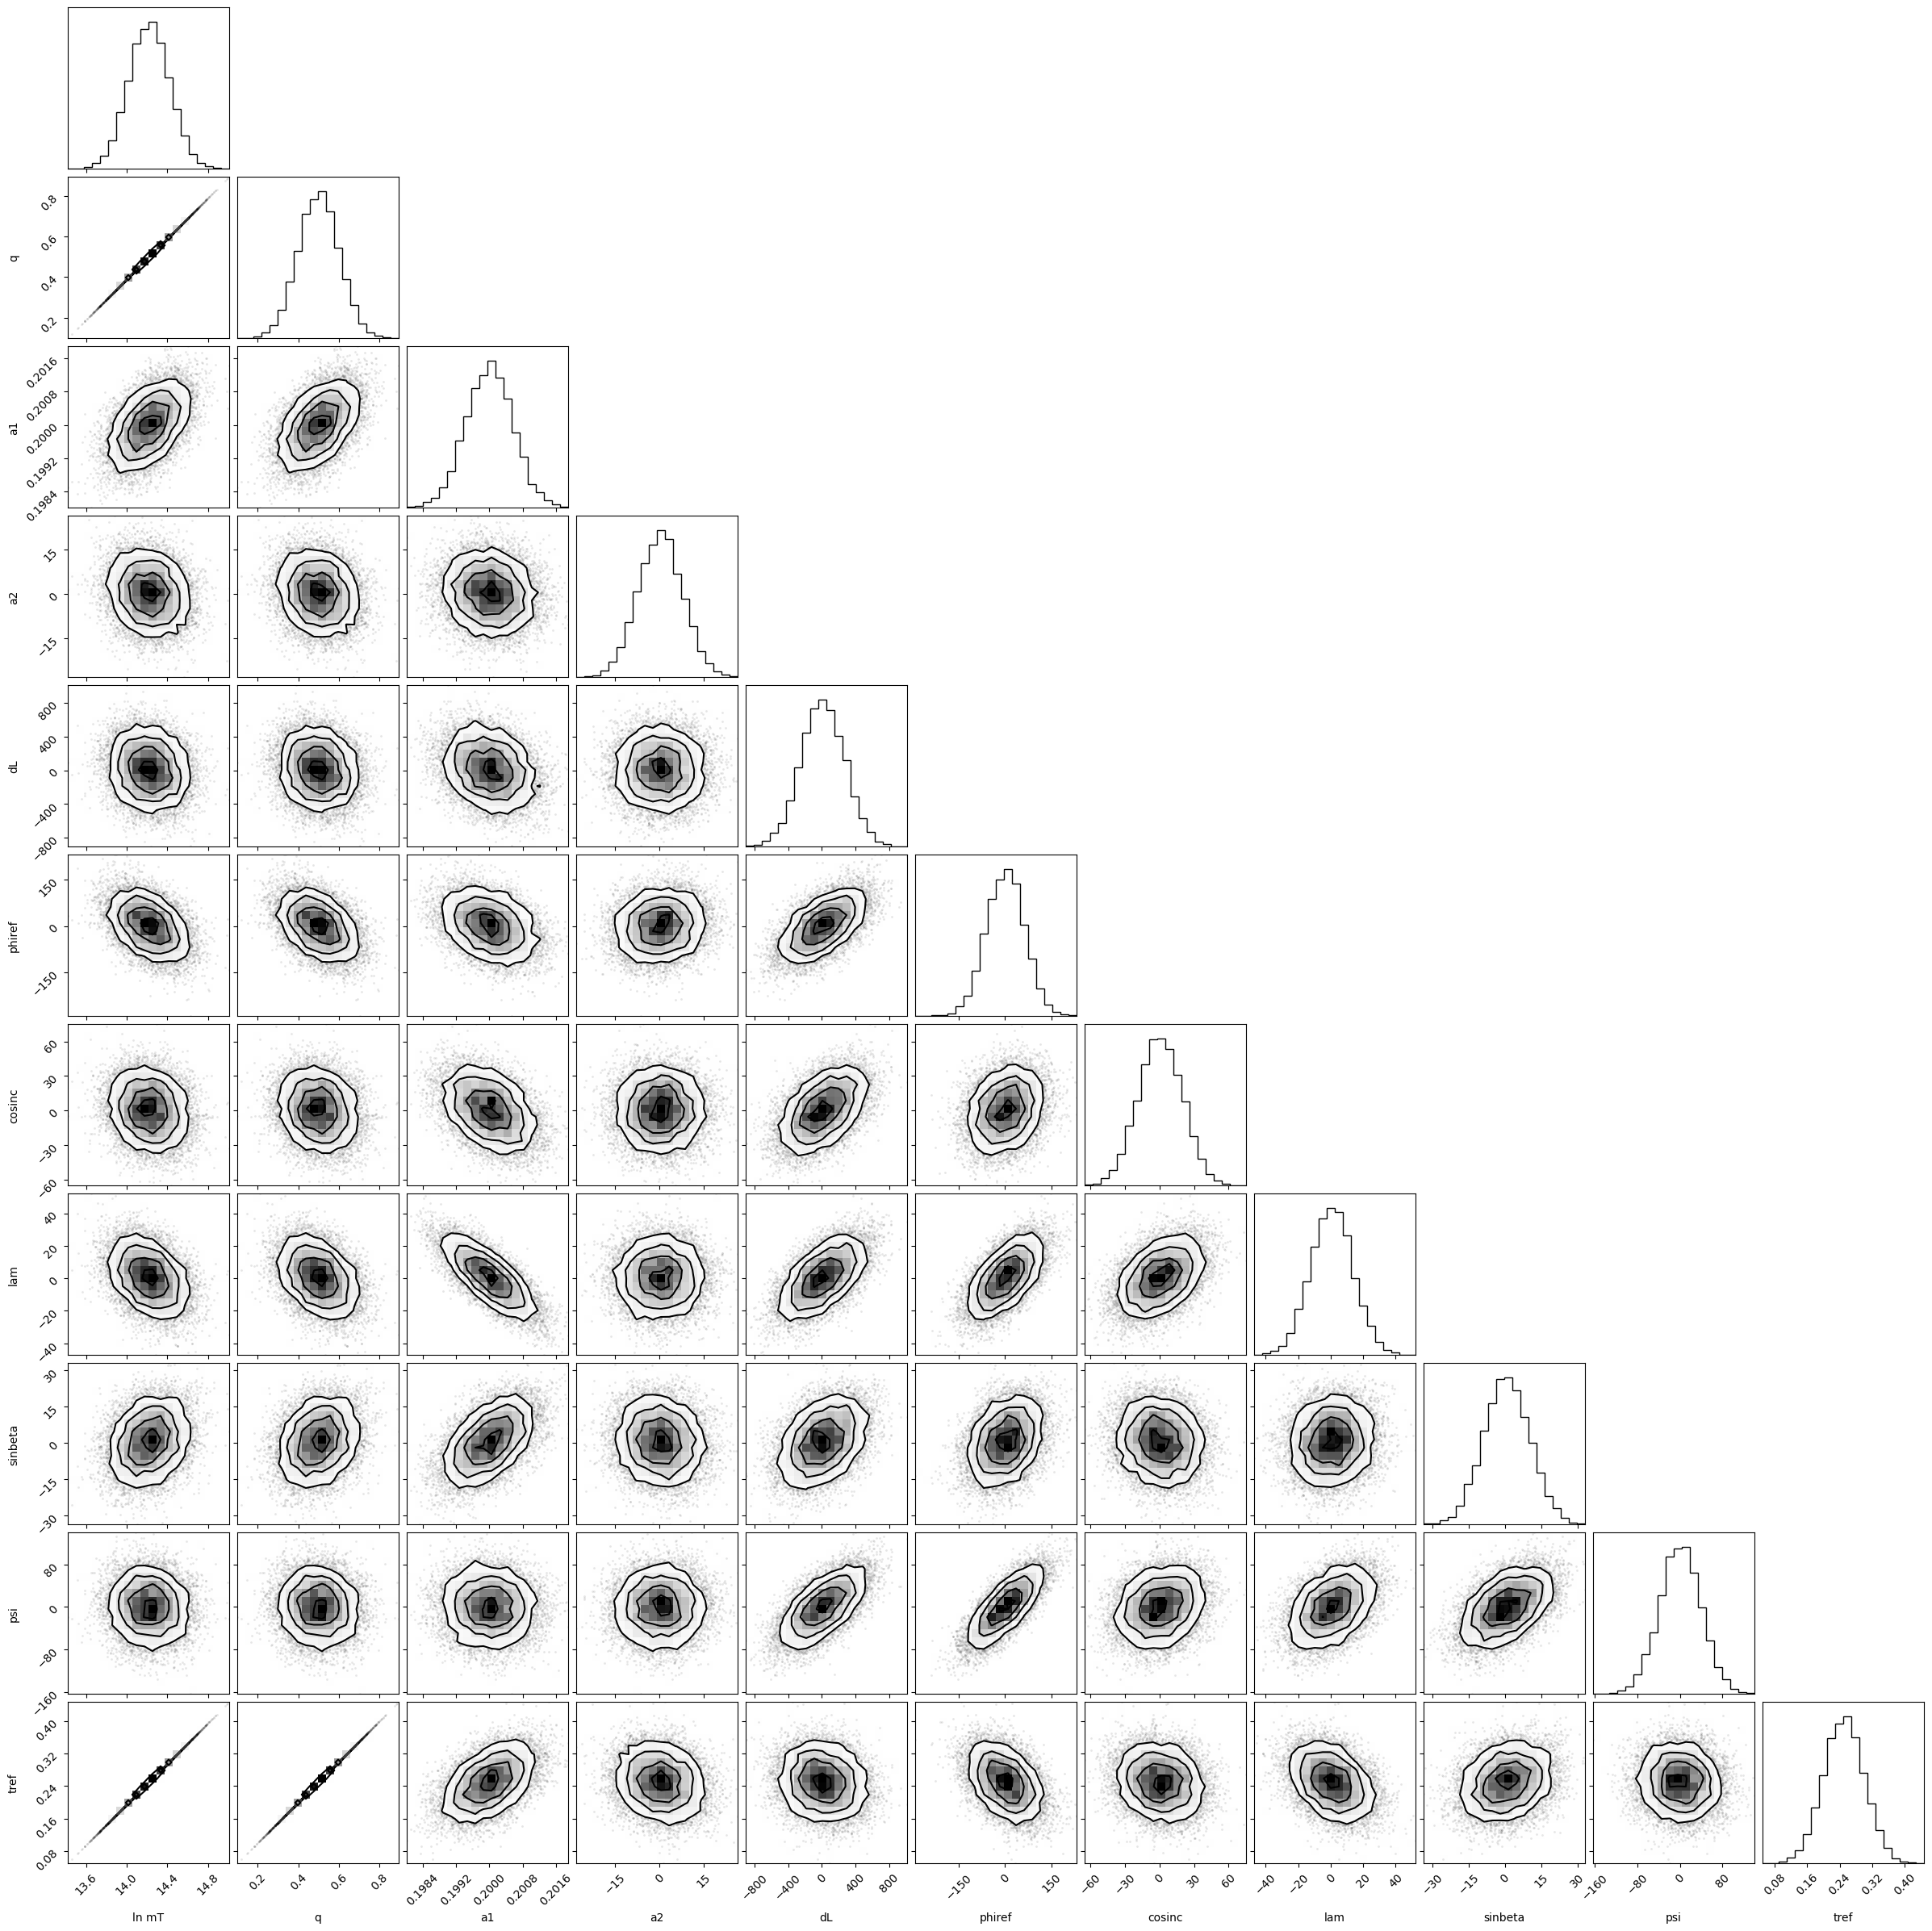

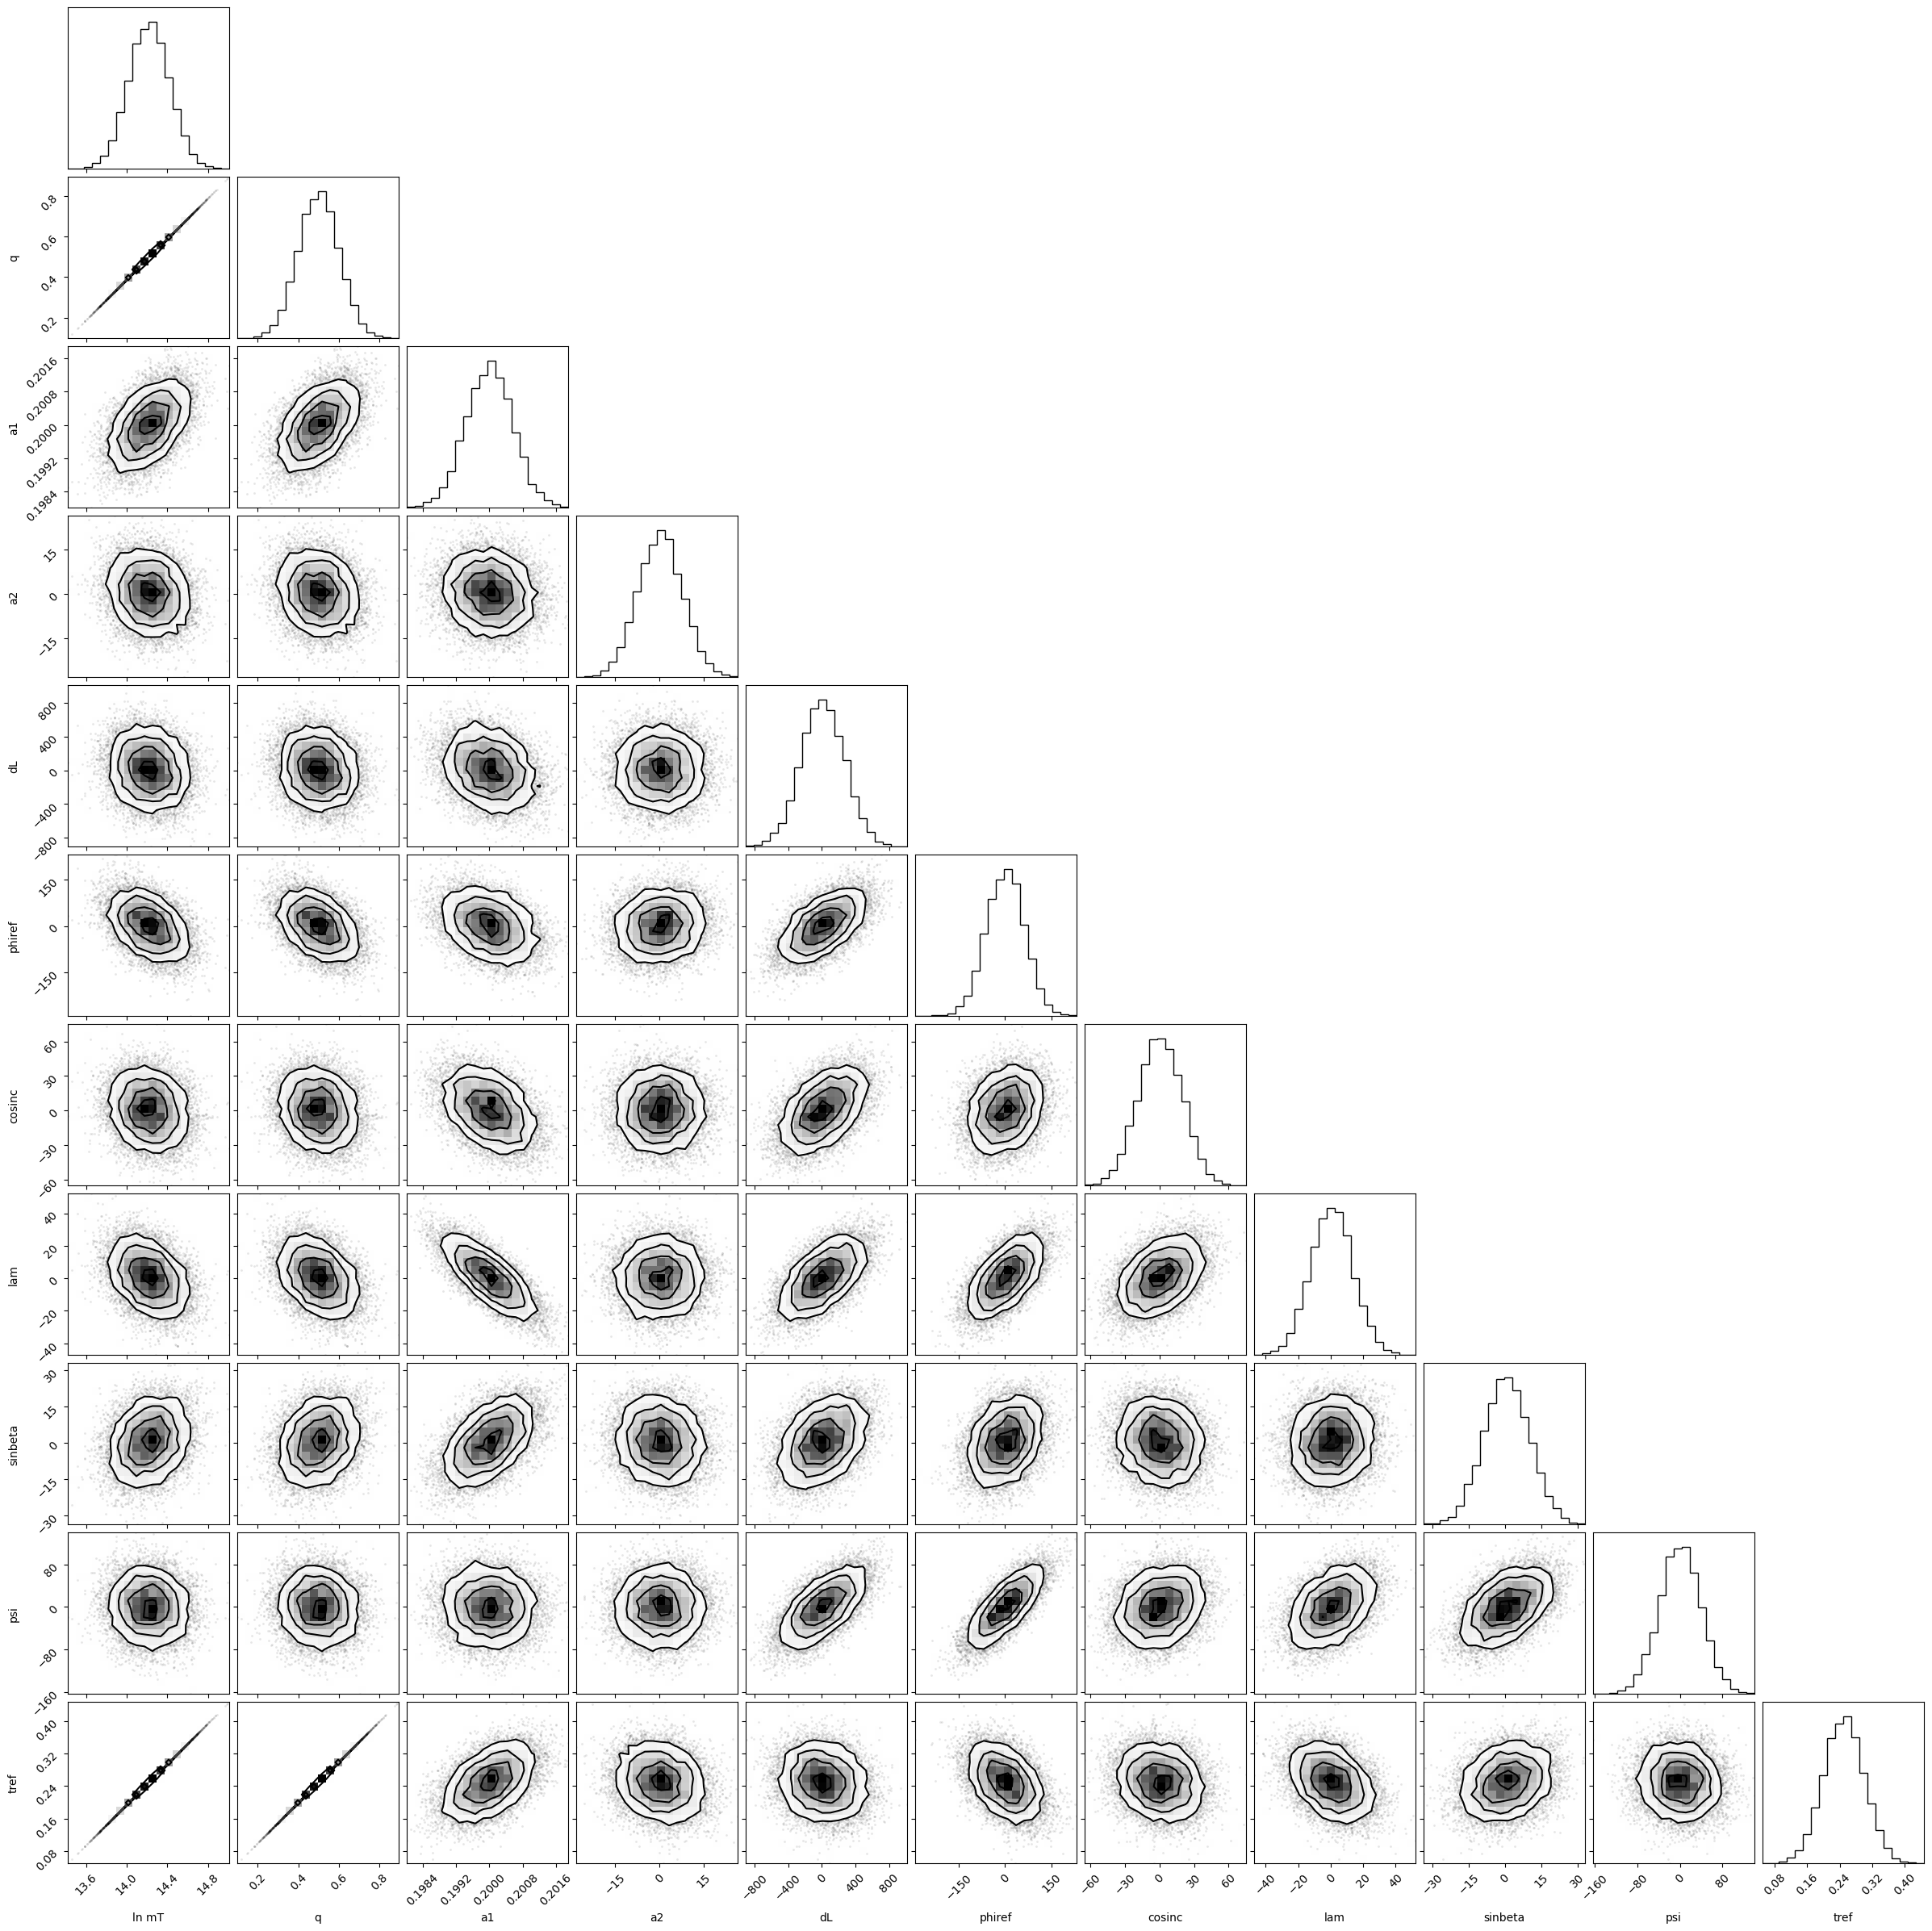

In [11]:
labels=["ln mT", "q", "a1", "a2", "dL", "phiref", "cosinc", "lam", "sinbeta", "psi", "tref"]
plot_covariance_corner(scaled_inj_params, cov, labels=labels, nsamp=10000)

### GBs

In [12]:
amp = 1e-22
f0 = 4e-3
fdot = 1e-18
fddot = 0.0
phi0 = 0.5
inc = 0.2
psi = 0.6
lam = 0.9
beta = -0.2
    
gb_injection_params = np.array([amp, f0, fdot, fddot, phi0, inc, psi, lam, beta])
fig, ax = plt.subplots(len(list(missions.keys())), 1, figsize=(8, 6))
for i, (name, mission) in enumerate(missions.items()):
    fn = mission["model"].fn
    print(name, mission["gb"].get_snr(*gb_injection_params))
    Sn = get_sensitivity(fn, model=mission["model"], sens_fn=A1TDISens, **mission["psd_kwargs"])
    ax[i].loglog(mission["gb"].f_arr, mission["gb"].f_arr * np.abs(mission["gb"].last_output[0]), c=f"C{i}")
    df = get_df(mission["Tobs"], mission["dt"])
    ax[i].loglog(fn, np.sqrt(fn) * (Sn / (4 * df)) ** (1/2), c=f"C{i}", ls="--")

lisa 138.06252284643315
lisamax 5790.213539338736
muares 24255.78888129018
do_con 0.9554344934380844
do_opt 0.955436489215776


In [13]:
scaled_inj_params, cov = mission["gb"].get_cov(
    *gb_injection_params,
    precision=True,
    more_accurate=False,
    eps=1e-11,
    deriv_inds=None,
)

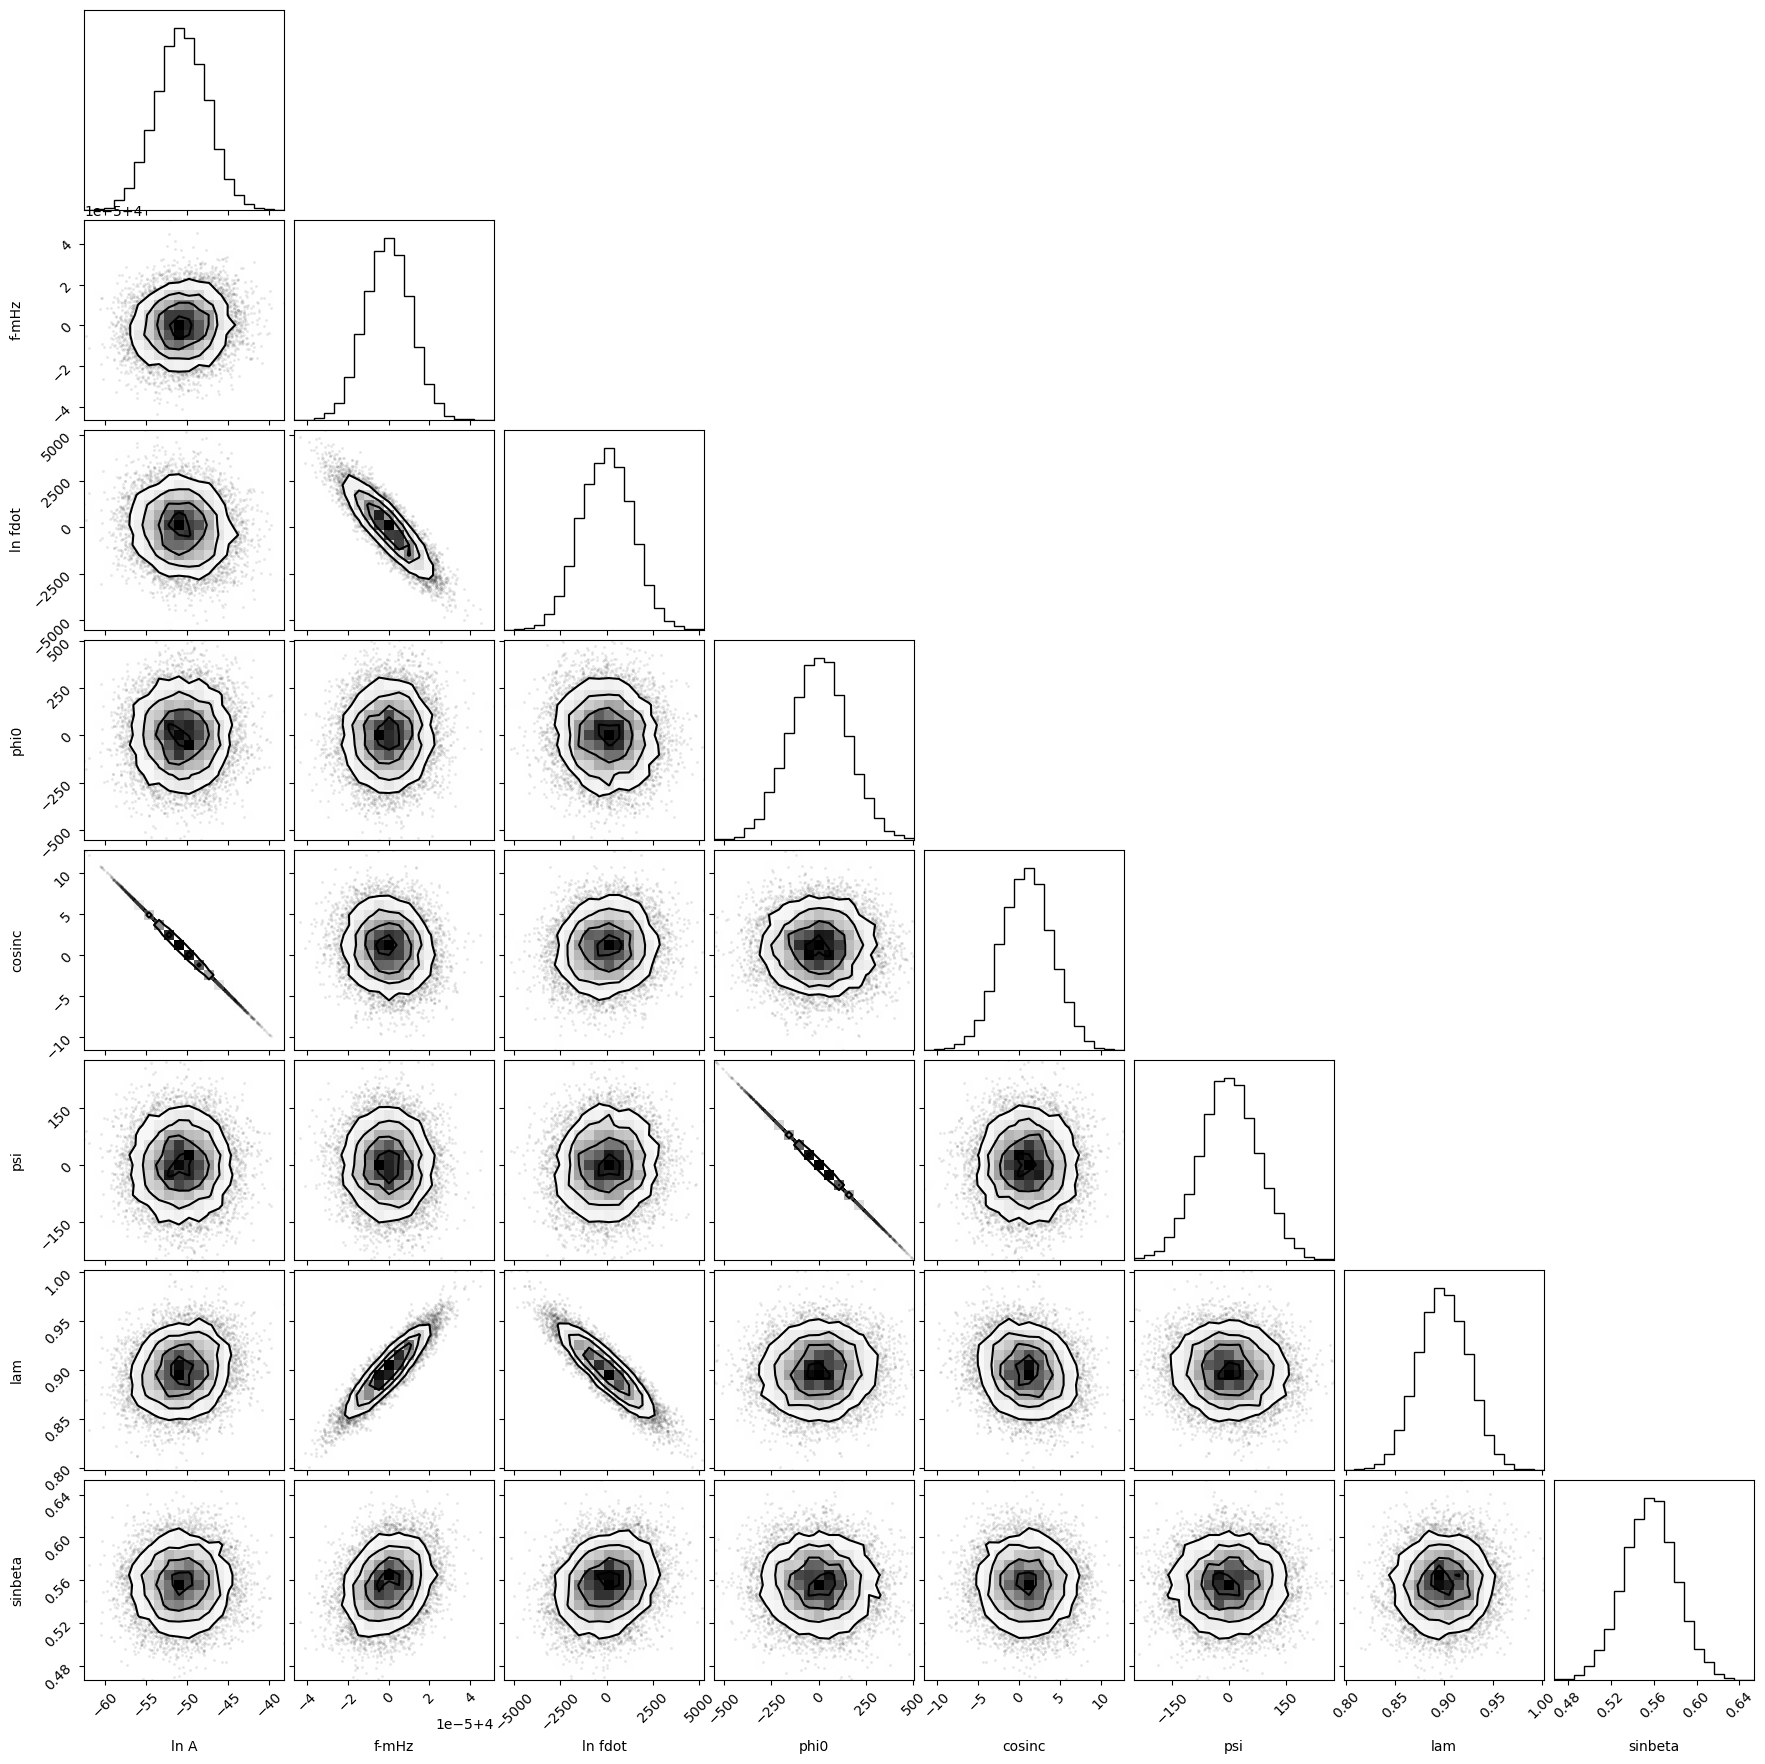

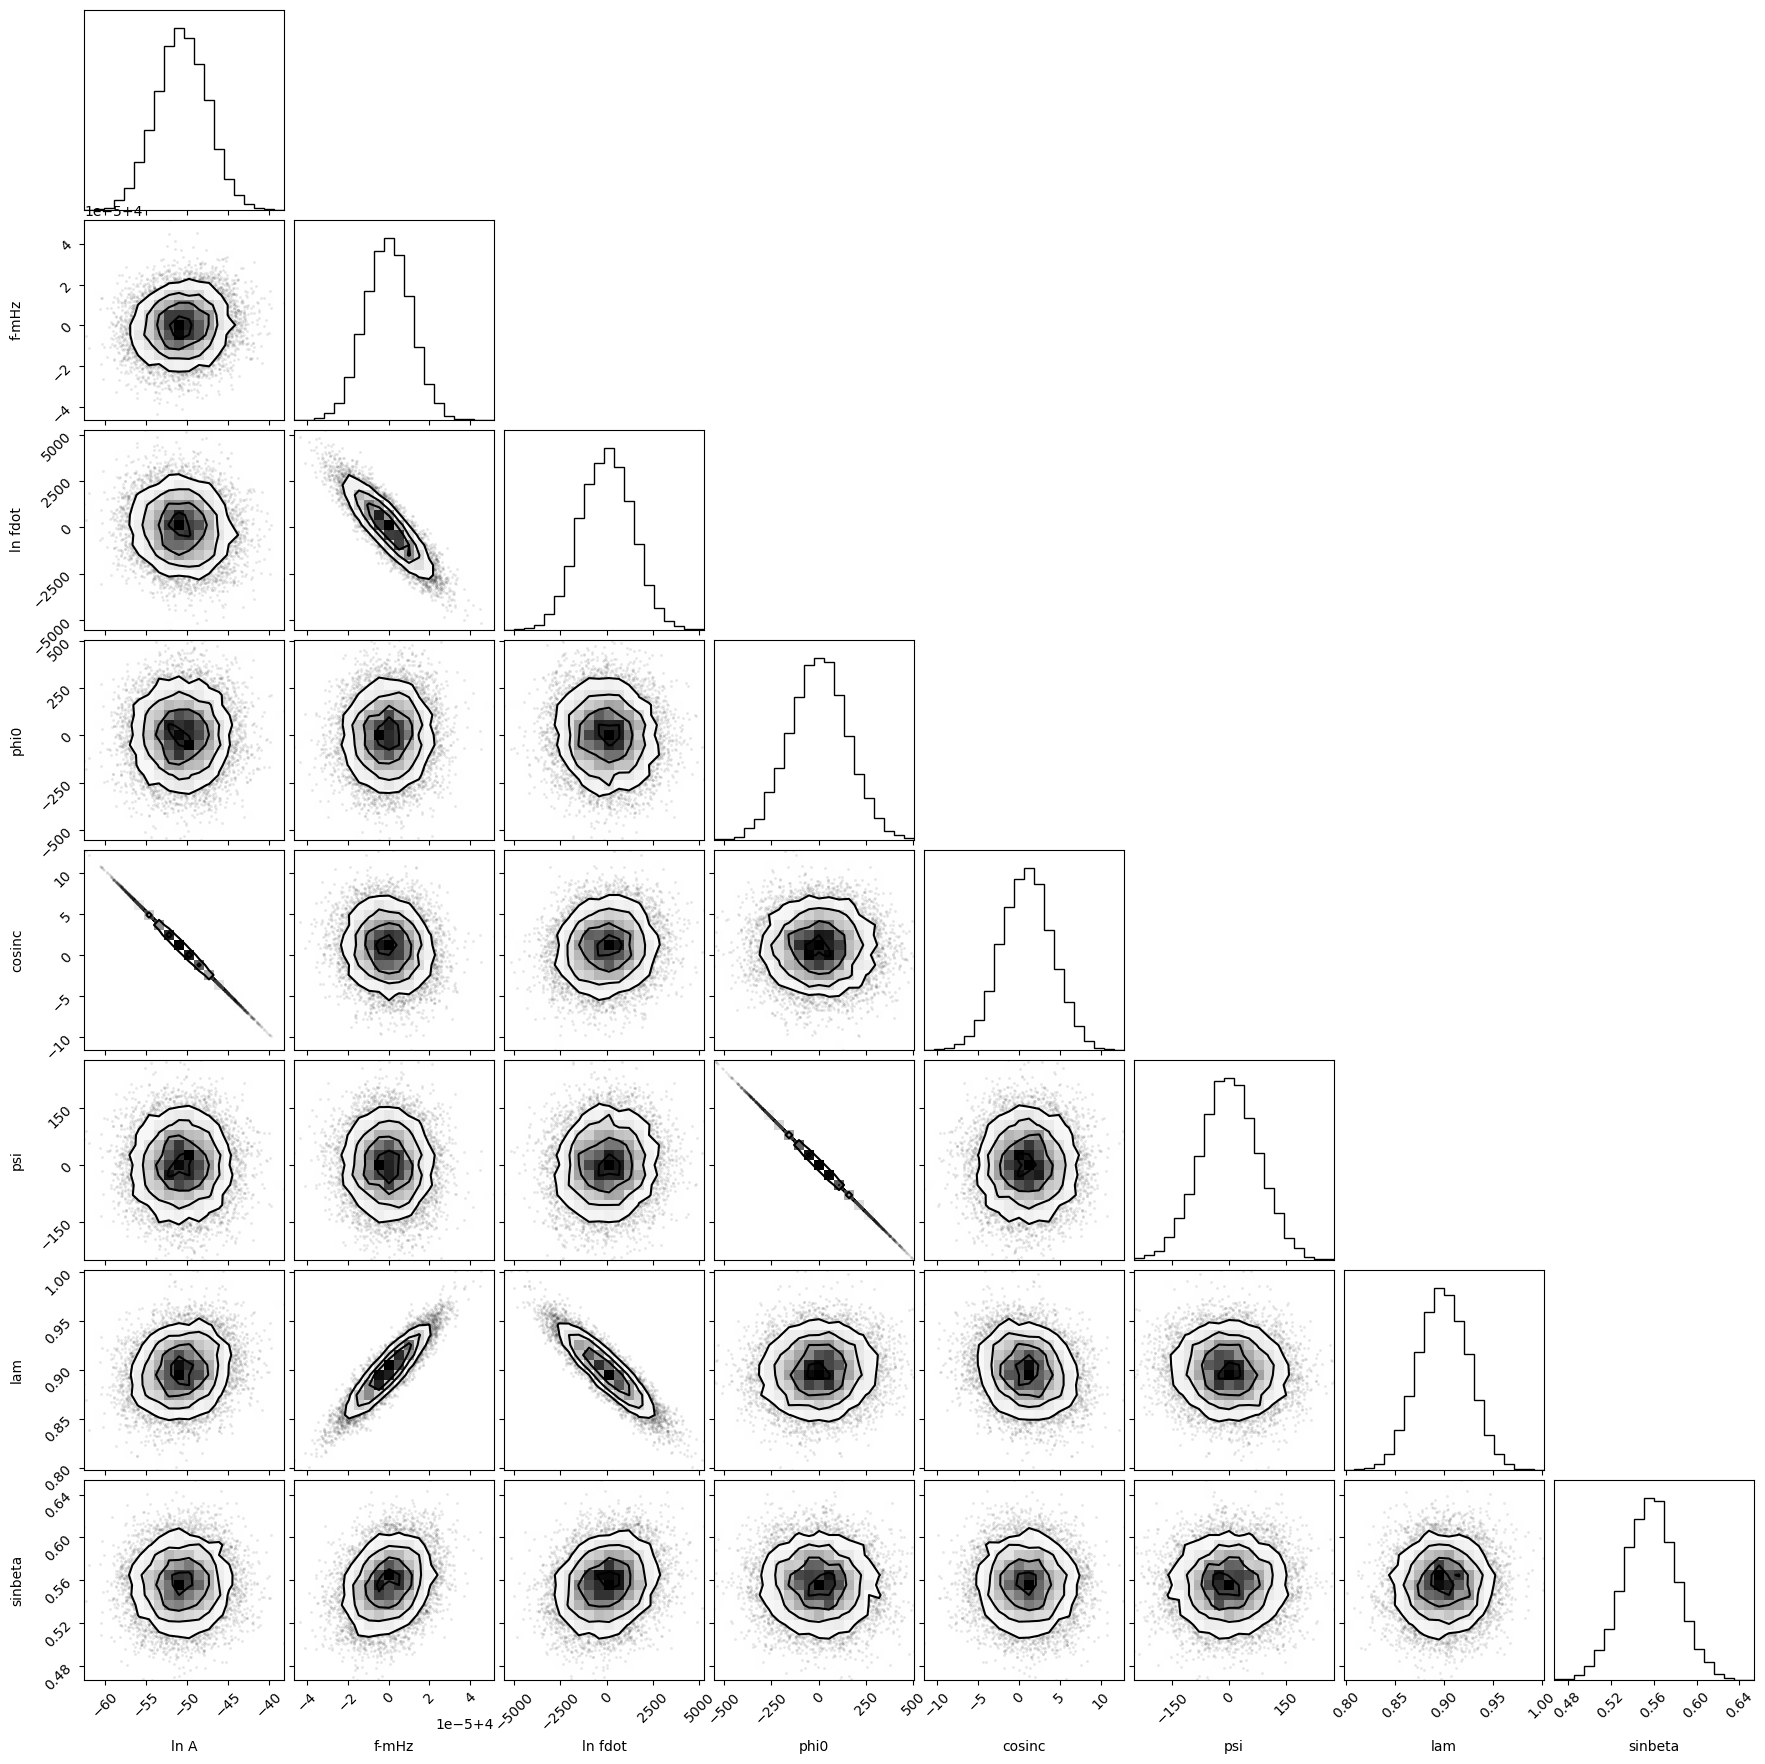

In [14]:
labels=["ln A", "f-mHz", "ln fdot", "phi0", "cosinc", "psi", "lam", "sinbeta"]
plot_covariance_corner(scaled_inj_params, cov, labels=labels, nsamp=10000)

#### VGBs Specifically

In [15]:
vgbs = pd.read_csv("vgbs.txt")

lisa b'HPLib' 21.971790547875592
lisa b'ZTFJ2320' 0.049886621318893924
lisa b'SDSSJ0923' 0.5511653849131476
lisa b'AMCVn' 39.95154072165763
lisa b'CX1751' 1.982070874090554
lisa b'ZTFJ2029' 1.6998033773022991
lisa b'SDSSJ0935' 21.292419663957325
lisa b'ZTFJ1539' 67.48901491502747
lisa b'SDSSJ2322' 9.879612009577885
lisa b'4U1820-30' 4.935844367963507
lisa b'HMCnc' 165.12240947931585
lisa b'CRBoo' 7.511415838543546
lisa b'PTFJ0533' 2.7041259496354026
lisa b'HD265435' 0.18764799191434567
lisa b'CDm30' 0.44667068955152733
lisa b'ZTFJ0640' 0.13011608184623671
lisa b'ZTFJ1749' 1.1060328018831103
lisa b'SMSSJ0338' 1.837804698098562
lisa b'SDSSJ1630' 0.9308051065199235
lisa b'ZTFJ2055' 0.08284832926061127
lisa b'ZTFJ1901' 0.42474046113423813
lisa b'ZTFJ1946' 0.2469270700966734
lisa b'ESCet' 49.16029295044196
lisa b'SDSSJ1337' 0.35836560075929746
lisa b'ZTFJ2130' 0.45721047822240607
lisa b'V407Vul' 60.052371651347514
lisa b'ZTFJ2243' 43.366431676999525
lisa b'SDSSJ0634' 7.515464016119724
lisa 

/Users/mlkatz1/miniconda3/envs/test_space_env_2/lib/python3.12/site-packages/lisatools/diagnostic.py:376: RuntimeWarning: invalid value encountered in sqrt
  opt_snr = np.sqrt(inner_product(sig1, sig1, *args, **kwargs).real)


muares b'ZTFJ1749' 6536.740667281542
muares b'SMSSJ0338' 18600.716160596392
muares b'SDSSJ1630' 9017.028178466287
muares b'ZTFJ2055' 5.558577683805676
muares b'ZTFJ1901' 4961.2922980690955
muares b'ZTFJ1946' 7942.464483609545
muares b'ESCet' 22225.494233746445
muares b'SDSSJ1337' 327912.48488730117
muares b'ZTFJ2130' 3978.9379724156483
muares b'V407Vul' nan
muares b'ZTFJ2243' 13746.871075141695
muares b'SDSSJ0634' 31007.14611435235
muares b'ZTFJ0722' 213106.65906084786
muares b'PTF1919' 1310.1557606475508
muares b'V803Cen' 43344.48942323202
muares b'SDSSJ1351' 76406.55084233847
muares b'SDSSJ1235' 1438.275658987328
muares b'ZTFJ0538' 56.88715758928483
muares b'SDSSJ0651' 14204.59987658837
muares b'SDSSJ1908' 6422.612516105557
do_con b'HPLib' 0.12468973267367697
do_con b'ZTFJ2320' 0.00021656893451855894
do_con b'SDSSJ0923' 0.003493506708776924
do_con b'AMCVn' 0.28028555133557553
do_con b'CX1751' 0.011625930348547472
do_con b'ZTFJ2029' 0.005969766046561353
do_con b'SDSSJ0935' 0.146876721

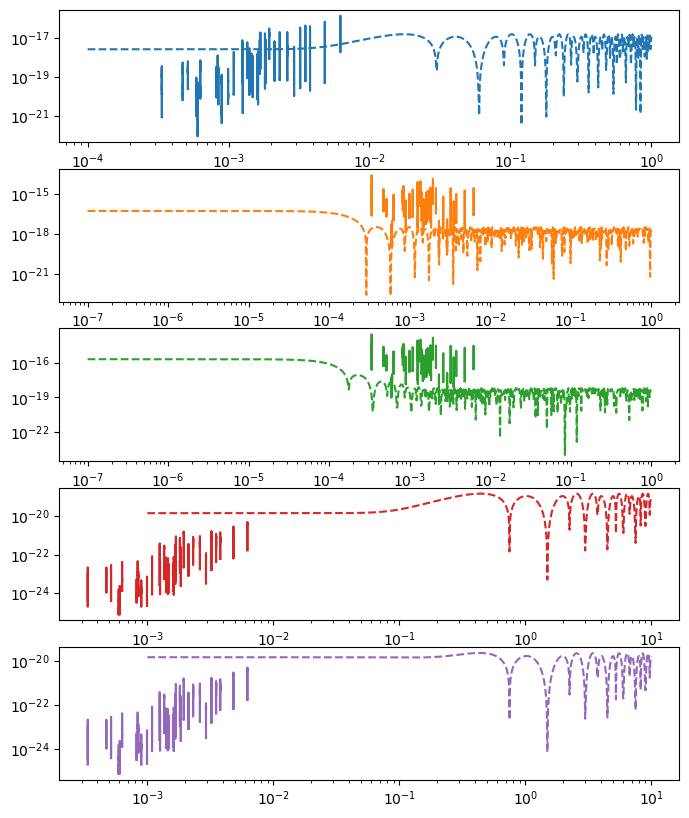

In [16]:
fig, ax = plt.subplots(len(list(missions.keys())), 1, figsize=(8, 2 * len(list(missions.keys()))))
for i, (name, mission) in enumerate(missions.items()):
    fn = mission["model"].fn
    Sn = get_sensitivity(fn, model=mission["model"], sens_fn=A1TDISens, **mission["psd_kwargs"])
    df = get_df(mission["Tobs"], mission["dt"])
    ax[i].loglog(fn, (Sn / (4 * df)) ** (1/2), c=f"C{i}", ls="--")
    for j in range(len(vgbs)):
        vgb = vgbs.iloc[j]
        params_in = np.array([
            vgb["Amplitude"],
            vgb["Frequency"],
            vgb["FrequencyDerivative"],
            0.0,
            vgb["InitialPhase"],
            vgb["Inclination"],
            vgb["Polarization"],
            vgb["EclipticLongitude"],
            vgb["EclipticLatitude"]
        ])
        print(name, vgb["Name"], mission["gb"].get_snr(*params_in, tdi2=True))
        ax[i].loglog(mission["gb"].f_arr, np.abs(mission["gb"].last_output[0]), c=f"C{i}")

### EMRIs

lisa 24.57191854448409
lisamax 3566.844533794439
muares nan


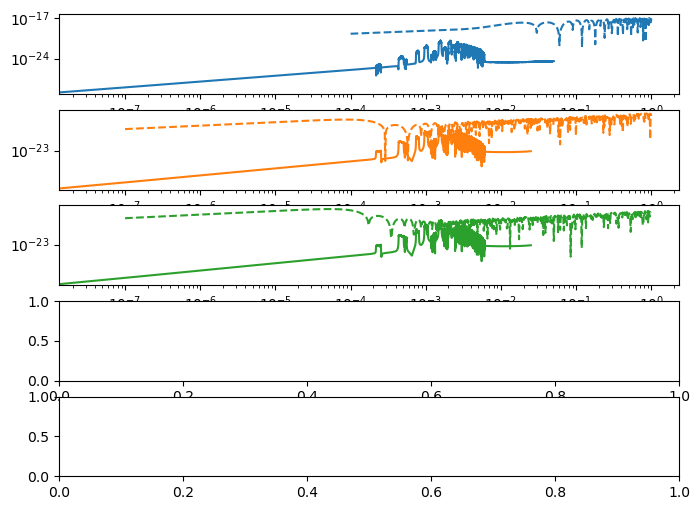

In [17]:
M = 1e6
mu = 1e1
a = 0.2
p0 = 12.0
e0 = 0.2
x0 = 0.1
dist = 3.0
phiS = 0.4423
qS = 0.523023
qK = 0.8923123
phiK = 0.1221209312
Phi_phi0 = 0.1231232
Phi_theta0 = 4.234903824
Phi_r0 = 3.230923

emri_injection_params = np.array(
    [M, mu, a, p0, e0, x0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0]
)

fig, ax = plt.subplots(len(list(missions.keys())), 1, figsize=(8, 6))

for i, (name, mission) in enumerate(missions.items()):
    # cannot handle decihertz without adjustments. 
    if name in ["do_con", "do_opt"]: 
        continue
    fn = mission["model"].fn
    print(name, mission["emri"].get_snr(*emri_injection_params))
    Sn = get_sensitivity(fn, model=mission["model"], sens_fn=A1TDISens, **mission["psd_kwargs"])
    emri_freqs = np.fft.rfftfreq(mission["emri"].last_output[0].shape[0], mission["emri"].aet_template_gen.dt)
    ax[i].loglog(emri_freqs, emri_freqs * np.abs(np.fft.rfft(mission["emri"].last_output[0])) * mission["emri"].aet_template_gen.dt, c=f"C{i}")
    ax[i].loglog(fn, np.sqrt(fn) * (Sn / (4 * df)) ** (1/2), c=f"C{i}", ls="--")
